# Exercise 2

Work on this before the next lecture on 12 April. We will talk about questions, comments, and solutions during the exercise after the third lecture.

Please do form study groups! When you do, make sure you can explain everything in your own words, do not simply copy&paste from others.

The solutions to a lot of these problems can probably be found with Google. Please don't. You will not learn a lot by copy&pasting from the internet.

If you want to get credit/examination on this course please upload your work to your GitHub repository for this course before the next lecture starts and post a link to your repository in [this thread](https://github.com/wildtreetech/advanced-computing-2018/issues/3). If you worked on things together with others please add their names to the notebook so we can see who formed groups.

In [24]:
%config InlineBackend.figure_format='retina'
%matplotlib inline

import numpy as np
np.random.seed(123)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["font.size"] = 14
from sklearn.utils import check_random_state

# Question 1

Build your own random forest classifier! Using the `DecisionTreeClassifier` from scikit-learn (http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) construct your own `RandomForestClassifier`.

There are two methods for adding randomisation to the tree growing process:

* grow each tree on a bootstrap sample of the data
* configure each tree to select a subset of features for each split

Try out your new `RandomForestClassifier` on the https://archive.ics.uci.edu/ml/datasets/bank+marketing dataset.

**Note:** To test your classifier it is a good idea to use a smaller dataset like the `make_blobs` from the lecture. It will run much faster and be easier to debug.

* Can you show that a forest of trees that are all the same performs like a single decision tree?
* Can you compute the correlation coefficient between scores assigned by two different trees in the forest? In order to gain from buildign a forest you want your trees to not be 100% correlated. Experiment with the different randomisation strategies to check that they work.

## Getting a "blob" dataset

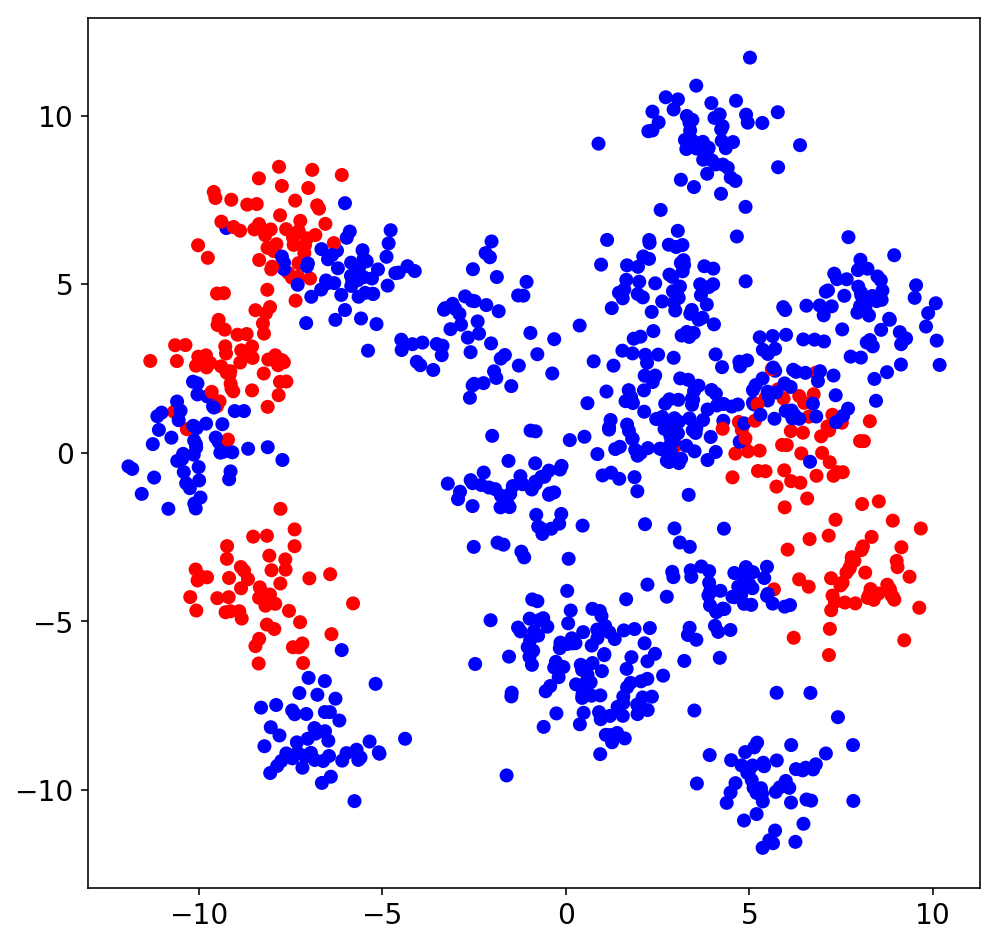

In [135]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

X, y = make_blobs(n_samples=1000, centers=20, random_state=10)
y = np.take(['r', 'b'], y<15)
plt.scatter(X[:, 0], X[:, 1], c=y)

## Building the RandomForestClassifier

### Playing around with a DecisionTreeClassifier

In [136]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [154]:
from sklearn.metrics import accuracy_score

test_split = np.linspace(0.1, 0.9, num=20)
n_trials = 100

score = np.zeros((2, ) + test_split.shape + (n_trials, ))
clf = DecisionTreeClassifier(max_leaf_nodes=15)

for i, split_fraction in enumerate(test_split):
    
    for j in range(n_trials):
    
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_fraction, shuffle=True)
        clf.fit(X_train, y_train)
    
        score[0, i, j] = accuracy_score(y_test, clf.predict(X_test))
        score[1, i, j] = accuracy_score(y_train, clf.predict(X_train))

score.shape

(2, 20, 100)

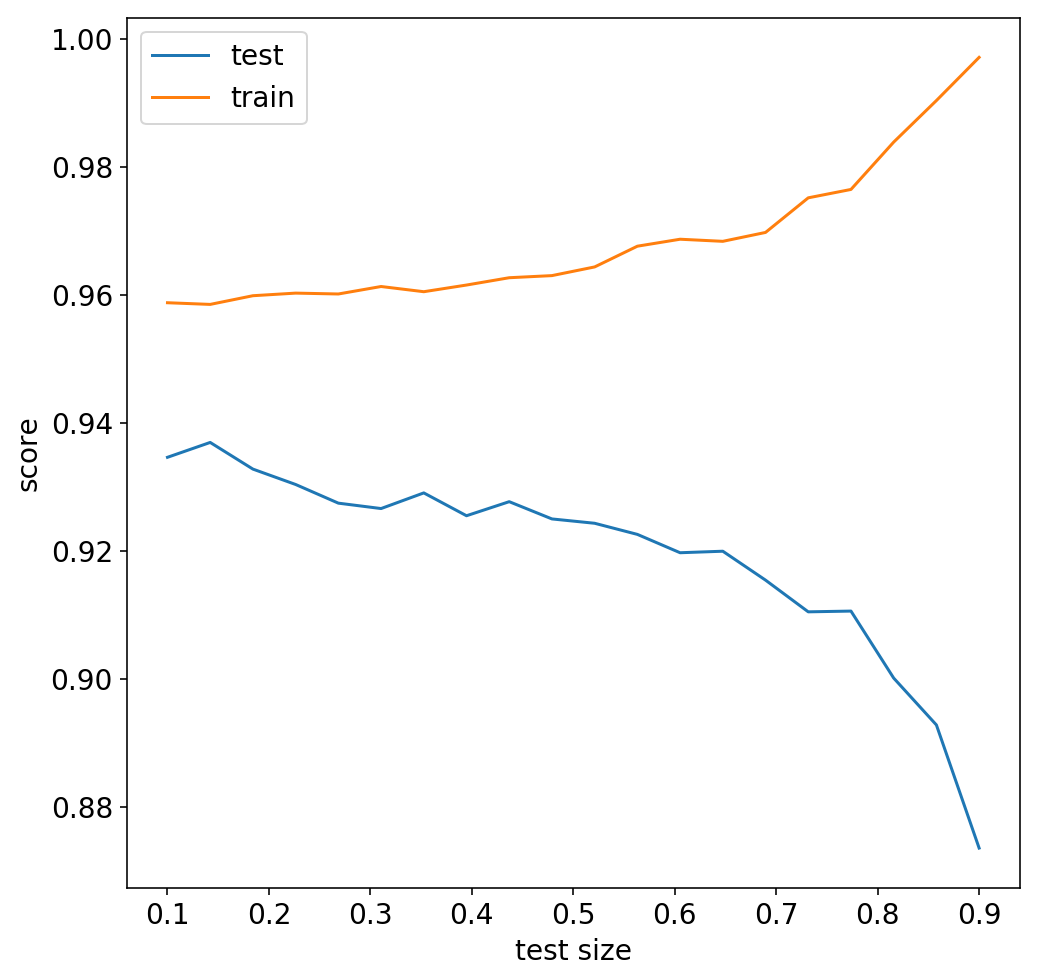

In [158]:
val = np.mean(score, axis=-1)
plt.plot(test_split, val[0], label='test')
plt.plot(test_split, val[1], label='train')
plt.xlabel('test size')
plt.ylabel('score')
plt.legend()

In [127]:
param_grid = {'max_leaf_nodes':np.arange(2, 30)}
grid = GridSearchCV(DecisionTreeClassifier(),
                    param_grid=param_grid,
                    cv=10,
                    return_train_score=True,
                    # scoring='roc_auc',
                )

grid.fit(X, y)

GridSearchCV(cv=10, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_leaf_nodes': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [128]:
results = grid.cv_results_
print(results.keys())

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_max_leaf_nodes', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'split5_test_score', 'split6_test_score', 'split7_test_score', 'split8_test_score', 'split9_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'split5_train_score', 'split6_train_score', 'split7_train_score', 'split8_train_score', 'split9_train_score', 'mean_train_score', 'std_train_score'])


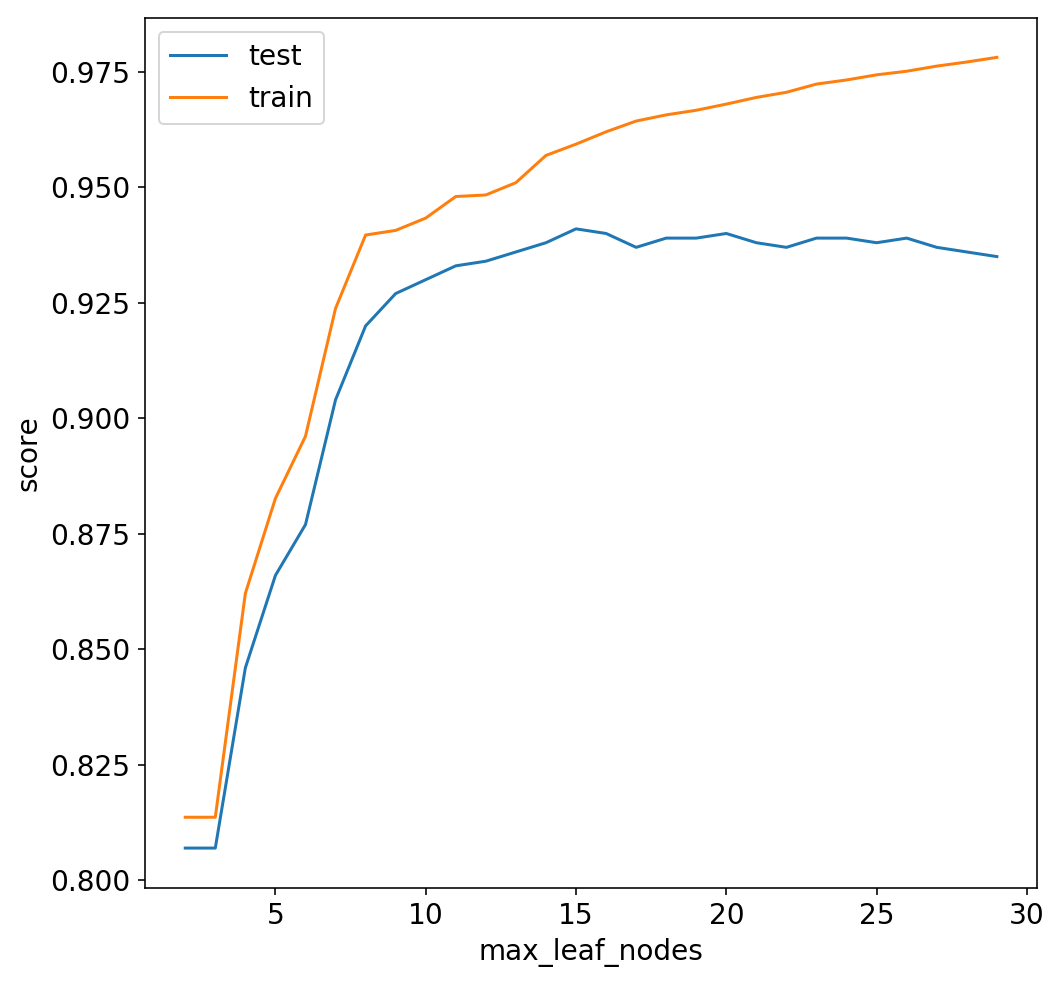

In [129]:

plt.plot(results['param_max_leaf_nodes'], results['mean_test_score'], label='test')
plt.plot(results['param_max_leaf_nodes'], results['mean_train_score'], label='train')
plt.legend(loc='best')
plt.xlabel('max_leaf_nodes')
plt.ylabel('score')

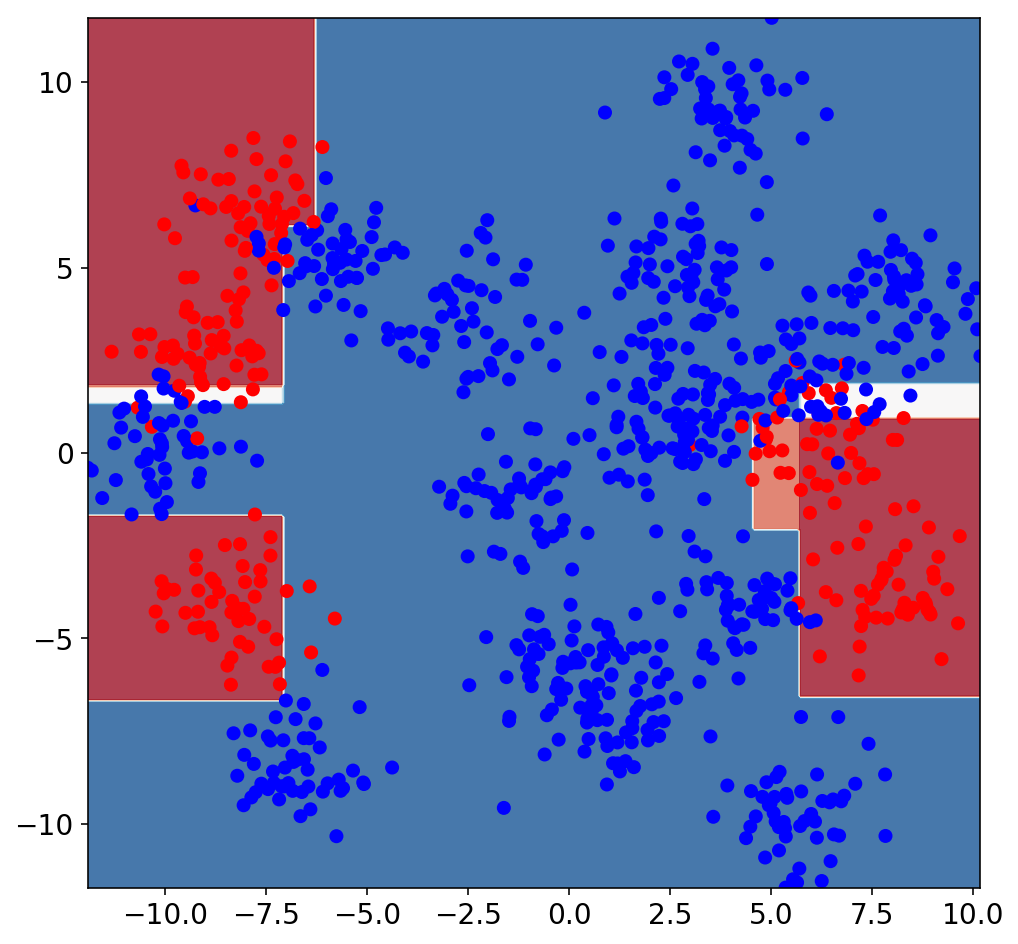

{'max_leaf_nodes': 15}


In [153]:
from utils import plot_surface

plot_surface(grid.best_estimator_, X, y)

print(grid.best_params_)

## RandomForestClassifier

In [221]:
from sklearn.cross_validation import ShuffleSplit

class CustomRandomForestClassifier:
    
    def __init__(self, n_trees, **params):
       
        self.n_trees = n_trees
        self.trees = [DecisionTreeClassifier(**params) for _ in range(n_trees)]
        self.trees_y = [None]*n_trees
        
        
    def fit(self, X, y):
        
        ss = ShuffleSplit(X.shape[0], n_iter=self.n_trees, test_size=0)
        
        for i, train_index in enumerate(ss):
        
            index = train_index[0]
            self.trees[i].fit(X[index], y[index])
            
    def predict(self, X):
        
        classes = self.trees[0].classes_
        
        print(classes)
        
        for i in range(self.n_trees):
            
            self.trees_y[i] = (self.trees[i].predict(X))
        
        y = np.array(self.trees_y)
        print(y)
        y = np.sum(y == classes[0], axis=0)
        
        mask_class_0 = y > self.n_trees
        y = y.astype(str)
        y[mask_class_0] = classes[0]
        y[~mask_class_0] = classes[1]
                
        return y         
            

In [222]:
my_random_forest = CustomRandomForestClassifier(10)

my_random_forest.fit(X, y)

my_random_forest.predict(X)

['b' 'r']
[['r' 'b' 'b' ... 'b' 'r' 'b']
 ['r' 'b' 'b' ... 'b' 'r' 'b']
 ['r' 'b' 'b' ... 'b' 'r' 'b']
 ...
 ['r' 'b' 'b' ... 'b' 'r' 'b']
 ['r' 'b' 'b' ... 'b' 'r' 'b']
 ['r' 'b' 'b' ... 'b' 'r' 'b']]


array(['r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r',
       'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r',
       'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r',
       'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r',
       'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r',
       'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r',
       'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r',
       'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r',
       'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r',
       'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r',
       'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r',
       'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r',
       'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r',
       'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r

# Question 2

Use the ready made `RandomForestClassifier` from scikit-learn to create the best model you can for the Bank Marketing dataset. Use `GridSearchCV` (or any other method) to tune your model and possible pre-processing steps. Make sure you have a test set to use after you are done tuning to estimate your generalisation error.

# Getting the dataset

In [25]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip bank-additional.zip
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip bank.zip


--2018-03-22 14:57:02--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.249
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.249|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 444572 (434K) [application/zip]
Saving to: ‘bank-additional.zip’

bank-additional.zip 100%[===================>] 434.15K   223KB/s    in 1.9s    

2018-03-22 14:57:04 (223 KB/s) - ‘bank-additional.zip’ saved [444572/444572]

--2018-03-22 14:57:04--  http://bank-additional.zip/
Resolving bank-additional.zip (bank-additional.zip)... failed: Name or service not known.
wget: unable to resolve host address ‘bank-additional.zip’
FINISHED --2018-03-22 14:57:04--
Total wall clock time: 2.7s
Downloaded: 1 files, 434K in 1.9s (223 KB/s)
--2018-03-22 14:57:04--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip
Resolving archive.ics.uci.edu (archive.ics.uc

In [26]:
!unzip -o bank.zip
!unzip -o bank-additional.zip

Archive:  bank.zip
  inflating: bank-full.csv           
  inflating: bank-names.txt          
  inflating: bank.csv                
Archive:  bank-additional.zip
  inflating: bank-additional/.DS_Store  
  inflating: __MACOSX/bank-additional/._.DS_Store  
  inflating: bank-additional/.Rhistory  
  inflating: bank-additional/bank-additional-full.csv  
  inflating: bank-additional/bank-additional-names.txt  
  inflating: bank-additional/bank-additional.csv  
  inflating: __MACOSX/._bank-additional  


In [27]:
!rm bank.zip bank-additional.zip
!ls

bank-additional  bank-full.csv	 exercise.ipynb  __MACOSX     __pycache__
bank.csv	 bank-names.txt  lecture.ipynb	 plots.ipynb  utils.py


In [86]:
import pandas as pd
filename = 'bank.csv'
df = pd.DataFrame.from_csv(filename, sep=';', index_col=None)
print(df.head())

features = df.columns.values
features = features[features != 'y']
X = df[features]
y = df['y']
print(X.shape, y.shape)

   age          job  marital  education default  balance housing loan  \
0   30   unemployed  married    primary      no     1787      no   no   
1   33     services  married  secondary      no     4789     yes  yes   
2   35   management   single   tertiary      no     1350     yes   no   
3   30   management  married   tertiary      no     1476     yes  yes   
4   59  blue-collar  married  secondary      no        0     yes   no   

    contact  day month  duration  campaign  pdays  previous poutcome   y  
0  cellular   19   oct        79         1     -1         0  unknown  no  
1  cellular   11   may       220         1    339         4  failure  no  
2  cellular   16   apr       185         1    330         1  failure  no  
3   unknown    3   jun       199         4     -1         0  unknown  no  
4   unknown    5   may       226         1     -1         0  unknown  no  
(4521, 16) (4521,)


/home/alispach/.anaconda3/envs/adv-comp-18/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  This is separate from the ipykernel package so we can avoid doing imports until


# Question 3

Compare the feature importances calculated by a `RandomForestClassifier`, `ExtraTreesClassifier` and `GradientBoostedTreesClassifier` on the california housing dataset. You might have to tune `n_estimators` and other hyper-parameters to get good performance.

Plot each of the features as a scatter plot with the target to learn about each variable. You can also make a plot of two features and use the target as colour.

Fit a model and tune the model complexity using a training and test data set.

Explore the feature importances and partial dependences that are important to the house price.

In [4]:
from sklearn.datasets.california_housing import fetch_california_housing

cal_housing = fetch_california_housing()

# if the above doesn't work, download `cal_housing_py3.pkl` from the GitHub repository
# and adjust the path to the downloaded file which is passed to `load()`
# uncomment the following lines
#from sklearn.externals.joblib import load
#d = load('/home/username/Downloads/cal_housing_py3.pkz')
#X, y = d[:,1:], d[:,0]/100000
#X[:, 2] /= X[:, 5]
#X[:, 3] /= X[:, 5]
#X[:, 5] = X[:, 4] / X[:, 5]

# your code here

# Question 4

Competition time! Use any model you want (and understand) to make the best model you can to predict the target in the below dataset.

Each student's submission will be ranked by:
* their performance (using [AUC ROC](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html) as metric) and
* how well they did at predicting their generalisation error.

Your final rank will be the average of your two ranks.

To evaluate how good you did at predicting your generalisation error Tim will release a fresh test data set after the hand-in deadline. You can then re-run your trained classifier on that data and score its performance. We will rank students by the difference between that score and their predicted score.

You can read in the data using the `pandas` library. The final column of the file contains the target (zero or one).

In [23]:
import pandas as pd

# you might have to adjust the path to the dataset
df_train = pd.read_csv("../../data/challenge-train.csv", header=None)
df_train.head()

ModuleNotFoundError: No module named 'pandas'

In [6]:
# convert the pandas dataframe to a numpy array
# make sure you do not include the final column
# in your training data (X) but store it as target (y)
X = df_train.as_matrix()[:, :-1]
y = df_train.as_matrix()[:, -1]

In [7]:
X.shape

(45000, 48)

In [8]:
y.shape

(45000,)